<a href="https://colab.research.google.com/github/BirukovAlex/neto_Python/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D0%B0_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Архитектуры сверточных сетей - Домашнее задание.**

Задача: обучить ResNet 18, VGG 16, Inception v3, DenseNet 161 на датасете EMNIST из torchvision и сравнить результаты

Устройство: GPU

## Импорт библиотек

In [2]:
import torch
import torch.nn as nn
import torchvision as tv
from torchsummary import summary
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Определяем устройство
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


## Блок 1: Функции для обучения и оценки

In [4]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            outputs = net(X)
            # Для Inception v3 обрабатываем возможные вспомогательные выходы
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Берем основной выход
            acc_sum += (outputs.argmax(axis=1) == y).sum()
            n += y.shape[0]
    return acc_sum.item() / n

def train_model(net, train_iter, test_iter, trainer, num_epochs, model_name):
    net.to(device)
    loss = nn.CrossEntropyLoss()

    train_losses = []
    train_accs = []
    test_accs = []
    times = []

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, step_size=1, gamma=0.9)

    for epoch in range(num_epochs):
        net.train()
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        batch_counter = 0

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()

            # Для Inception v3 обрабатываем выходы
            outputs = net(X)
            if isinstance(outputs, tuple):
                main_output, aux_output = outputs
                main_loss = loss(main_output, y)
                aux_loss = loss(aux_output, y)
                l = main_loss + 0.3 * aux_loss  # Вес вспомогательных выходов
                y_hat = main_output
            else:
                y_hat = outputs
                l = loss(y_hat, y)

            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            batch_counter += 1

            # Ограничиваем количество батчей до 126
            if batch_counter >= 126:
                break

        # Обновляем learning rate
        scheduler.step()

        epoch_time = time.time() - start
        train_loss = train_l_sum / (i + 1)  # Среднее по батчам
        train_acc = train_acc_sum / n
        test_acc = evaluate_accuracy(test_iter, net)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        times.append(epoch_time)

        current_lr = scheduler.get_last_lr()[0]
        print(f'{model_name} - Эпоха {epoch + 1} (lr={current_lr:.6f}):')
        print(f'  Потери: {train_loss:.4f}, Точность на обучении: {train_acc:.3f}, Точность на тесте: {test_acc:.3f}, Время: {epoch_time:.1f} сек')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'times': times
    }

## Блок 2: Загрузка и подготовка данных EMNIST

In [5]:
def prepare_data(batch_size=128):
    # Преобразования для изображений - преобразуем grayscale в RGB
    transforms = tv.transforms.Compose([
        tv.transforms.Resize((224, 224)),  # Больше размер для лучшего качества
        tv.transforms.Grayscale(num_output_channels=3),  # Преобразуем в RGB
        tv.transforms.RandomRotation(10),  # Аугментация
        tv.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Аугментация
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Для теста без аугментации
    test_transforms = tv.transforms.Compose([
        tv.transforms.Resize((224, 224)),
        tv.transforms.Grayscale(num_output_channels=3),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Загружаем EMNIST (буквы)
    train_dataset = tv.datasets.EMNIST(
        '.',
        split='letters',  # 27 классов (N/A + a-z)
        train=True,
        transform=transforms,
        download=True
    )

    test_dataset = tv.datasets.EMNIST(
        '.',
        split='letters',
        train=False,
        transform=test_transforms,
        download=True
    )

    print(f"\nИнформация о данных:")
    print(f"Классов: {len(train_dataset.classes)}")
    print(f"Размер обучающего набора: {len(train_dataset)}")
    print(f"Размер тестового набора: {len(test_dataset)}")
    print(f"Batch size: {batch_size}")

    # Создаем DataLoader
    train_iter = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True if device == 'cuda' else False,
        drop_last=True  # Отбрасываем последний неполный батч
    )

    test_iter = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True if device == 'cuda' else False
    )

    return train_iter, test_iter, len(train_dataset.classes)

### Подготовка данных

In [6]:
BATCH_SIZE = 128
train_iter, test_iter, num_classes = prepare_data(BATCH_SIZE)


Информация о данных:
Классов: 27
Размер обучающего набора: 124800
Размер тестового набора: 20800
Batch size: 128


## Блок 3: Настройка моделей с размороженными слоями

### ResNet-18

In [7]:
print("\n1. Настройка ResNet-18...")
resnet18 = tv.models.resnet18(pretrained=True)

# Размораживаем последние слои для лучшего обучения
for param in resnet18.parameters():
    param.requires_grad = False

# Размораживаем последние 2 блока
for param in resnet18.layer3.parameters():
    param.requires_grad = True
for param in resnet18.layer4.parameters():
    param.requires_grad = True

# Заменяем последний полносвязный слой
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

# Размораживаем новый классификатор
for param in resnet18.fc.parameters():
    param.requires_grad = True

resnet18.to(device)
print(f"ResNet-18 настроен. Обучаемые параметры: {sum(p.numel() for p in resnet18.parameters() if p.requires_grad):,}")


1. Настройка ResNet-18...
ResNet-18 настроен. Обучаемые параметры: 10,769,947


###VGG-16

In [8]:
print("\n2. Настройка VGG-16...")
vgg16 = tv.models.vgg16(pretrained=True)

# Размораживаем последние слои
for param in vgg16.parameters():
    param.requires_grad = False

# Размораживаем последние слои features
for param in vgg16.features[-6:].parameters():  # Последние 6 слоев
    param.requires_grad = True

# Заменяем классификатор
num_features = vgg16.classifier[6].in_features
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)

# Размораживаем весь классификатор
for param in vgg16.classifier.parameters():
    param.requires_grad = True

vgg16.to(device)
print(f"VGG-16 настроен. Обучаемые параметры: {sum(p.numel() for p in vgg16.parameters() if p.requires_grad):,}")


2. Настройка VGG-16...
VGG-16 настроен. Обучаемые параметры: 124,376,091


###Inception v3

In [9]:
print("\n3. Настройка Inception v3...")
# Для Inception v3 создаем отдельный датасет с размером 299x299
transforms_inception = tv.transforms.Compose([
    tv.transforms.Resize((299, 299)),
    tv.transforms.Grayscale(num_output_channels=3),
    tv.transforms.RandomRotation(10),
    tv.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms_inception = tv.transforms.Compose([
    tv.transforms.Resize((299, 299)),
    tv.transforms.Grayscale(num_output_channels=3),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загружаем данные
train_dataset_inception = tv.datasets.EMNIST(
    '.',
    split='letters',
    train=True,
    transform=transforms_inception,
    download=False
)

test_dataset_inception = tv.datasets.EMNIST(
    '.',
    split='letters',
    train=False,
    transform=test_transforms_inception,
    download=False
)

train_iter_inception = torch.utils.data.DataLoader(
    train_dataset_inception,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device == 'cuda' else False,
    drop_last=True
)

test_iter_inception = torch.utils.data.DataLoader(
    test_dataset_inception,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == 'cuda' else False
)

# Inception v3 с включенными вспомогательными выходами
inception_v3 = tv.models.inception_v3(pretrained=True, aux_logits=True)

# Размораживаем последние слои
for param in inception_v3.parameters():
    param.requires_grad = False

# Размораживаем последние блоки
for param in inception_v3.Mixed_7a.parameters():
    param.requires_grad = True
for param in inception_v3.Mixed_7b.parameters():
    param.requires_grad = True
for param in inception_v3.Mixed_7c.parameters():
    param.requires_grad = True

# Модифицируем выходы
num_features = inception_v3.fc.in_features
num_aux_features = inception_v3.AuxLogits.fc.in_features

inception_v3.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, num_classes)
)

inception_v3.AuxLogits.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_aux_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

# Размораживаем выходные слои
for param in inception_v3.fc.parameters():
    param.requires_grad = True
for param in inception_v3.AuxLogits.fc.parameters():
    param.requires_grad = True

inception_v3.to(device)
print(f"Inception v3 настроен. Обучаемые параметры: {sum(p.numel() for p in inception_v3.parameters() if p.requires_grad):,}")


3. Настройка Inception v3...
Inception v3 настроен. Обучаемые параметры: 15,353,142


###DenseNet-161

In [10]:
print("\n4. Настройка DenseNet-161...")
densenet161 = tv.models.densenet161(pretrained=True)

# Размораживаем последние слои
for param in densenet161.parameters():
    param.requires_grad = False

# Размораживаем последний блок denseblock
for param in densenet161.features.denseblock4.parameters():
    param.requires_grad = True

# Заменяем классификатор
num_features = densenet161.classifier.in_features
densenet161.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, num_classes)
)

# Размораживаем классификатор
for param in densenet161.classifier.parameters():
    param.requires_grad = True

densenet161.to(device)
print(f"DenseNet-161 настроен. Обучаемые параметры: {sum(p.numel() for p in densenet161.parameters() if p.requires_grad):,}")



4. Настройка DenseNet-161...
DenseNet-161 настроен. Обучаемые параметры: 11,776,411


## Блок 4: Обучение моделей

###ResNet-18

In [11]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

optimizer_resnet = torch.optim.AdamW(params_to_update, lr=0.0003, weight_decay=1e-4)
results_resnet = train_model(resnet18, train_iter, test_iter, optimizer_resnet, 3, "ResNet-18")

ResNet-18 - Эпоха 1 (lr=0.000270):
  Потери: 0.9843, Точность на обучении: 0.733, Точность на тесте: 0.918, Время: 37.6 сек
ResNet-18 - Эпоха 2 (lr=0.000243):
  Потери: 0.2979, Точность на обучении: 0.905, Точность на тесте: 0.922, Время: 37.9 сек
ResNet-18 - Эпоха 3 (lr=0.000219):
  Потери: 0.2448, Точность на обучении: 0.920, Точность на тесте: 0.927, Время: 39.0 сек


###VGG-16

In [12]:
params_to_update = []
for name, param in vgg16.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

optimizer_vgg = torch.optim.AdamW(params_to_update, lr=0.0003, weight_decay=1e-4)
results_vgg = train_model(vgg16, train_iter, test_iter, optimizer_vgg, 3, "VGG-16")

VGG-16 - Эпоха 1 (lr=0.000270):
  Потери: 0.7718, Точность на обучении: 0.767, Точность на тесте: 0.908, Время: 85.0 сек
VGG-16 - Эпоха 2 (lr=0.000243):
  Потери: 0.3150, Точность на обучении: 0.898, Точность на тесте: 0.924, Время: 85.1 сек
VGG-16 - Эпоха 3 (lr=0.000219):
  Потери: 0.2636, Точность на обучении: 0.912, Точность на тесте: 0.929, Время: 84.8 сек


###Inception v3

In [13]:
params_to_update = []
for name, param in inception_v3.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

optimizer_inception = torch.optim.AdamW(params_to_update, lr=0.0002, weight_decay=1e-4)
results_inception = train_model(inception_v3, train_iter_inception, test_iter_inception,
                                optimizer_inception, 3, "Inception v3")

Inception v3 - Эпоха 1 (lr=0.000180):
  Потери: 2.8937, Точность на обучении: 0.426, Точность на тесте: 0.785, Время: 45.1 сек
Inception v3 - Эпоха 2 (lr=0.000162):
  Потери: 1.2736, Точность на обучении: 0.812, Точность на тесте: 0.872, Время: 44.9 сек
Inception v3 - Эпоха 3 (lr=0.000146):
  Потери: 1.0110, Точность на обучении: 0.864, Точность на тесте: 0.886, Время: 45.2 сек


###DenseNet-161

In [14]:
params_to_update = []
for name, param in densenet161.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

optimizer_densenet = torch.optim.AdamW(params_to_update, lr=0.0002, weight_decay=1e-4)
results_densenet = train_model(densenet161, train_iter, test_iter, optimizer_densenet, 3, "DenseNet-161")

DenseNet-161 - Эпоха 1 (lr=0.000180):
  Потери: 1.3092, Точность на обучении: 0.635, Точность на тесте: 0.878, Время: 135.8 сек
DenseNet-161 - Эпоха 2 (lr=0.000162):
  Потери: 0.3826, Точность на обучении: 0.879, Точность на тесте: 0.908, Время: 136.1 сек
DenseNet-161 - Эпоха 3 (lr=0.000146):
  Потери: 0.2993, Точность на обучении: 0.900, Точность на тесте: 0.916, Время: 135.9 сек


##Блок 5: Сводная таблица результатов

In [15]:
# Создаем DataFrame для результатов
results_summary = pd.DataFrame({
    'Модель': ['ResNet-18', 'VGG-16', 'Inception v3', 'DenseNet-161'],
    'Финальная точность (тест)': [
        results_resnet['test_accs'][-1],
        results_vgg['test_accs'][-1],
        results_inception['test_accs'][-1],
        results_densenet['test_accs'][-1]
    ],
    'Лучшая точность (тест)': [
        max(results_resnet['test_accs']),
        max(results_vgg['test_accs']),
        max(results_inception['test_accs']),
        max(results_densenet['test_accs'])
    ],
    'Финальные потери': [
        results_resnet['train_losses'][-1],
        results_vgg['train_losses'][-1],
        results_inception['train_losses'][-1],
        results_densenet['train_losses'][-1]
    ],
    'Среднее время эпохи (сек)': [
        sum(results_resnet['times'])/len(results_resnet['times']),
        sum(results_vgg['times'])/len(results_vgg['times']),
        sum(results_inception['times'])/len(results_inception['times']),
        sum(results_densenet['times'])/len(results_densenet['times'])
    ],
    'Общее время (сек)': [
        sum(results_resnet['times']),
        sum(results_vgg['times']),
        sum(results_inception['times']),
        sum(results_densenet['times'])
    ]
})

# Форматируем вывод
pd.set_option('display.float_format', '{:.4f}'.format)
print("\nРезультаты обучения (3 эпохи, 126 батчей на эпоху):")
print(results_summary.to_string(index=False))


Результаты обучения (3 эпохи, 126 батчей на эпоху):
      Модель  Финальная точность (тест)  Лучшая точность (тест)  Финальные потери  Среднее время эпохи (сек)  Общее время (сек)
   ResNet-18                     0.9268                  0.9268            0.2448                    38.1856           114.5568
      VGG-16                     0.9290                  0.9290            0.2636                    84.9764           254.9293
Inception v3                     0.8858                  0.8858            1.0110                    45.0598           135.1793
DenseNet-161                     0.9165                  0.9165            0.2993                   135.9529           407.8588


## Блок 6: Визуализация результатов

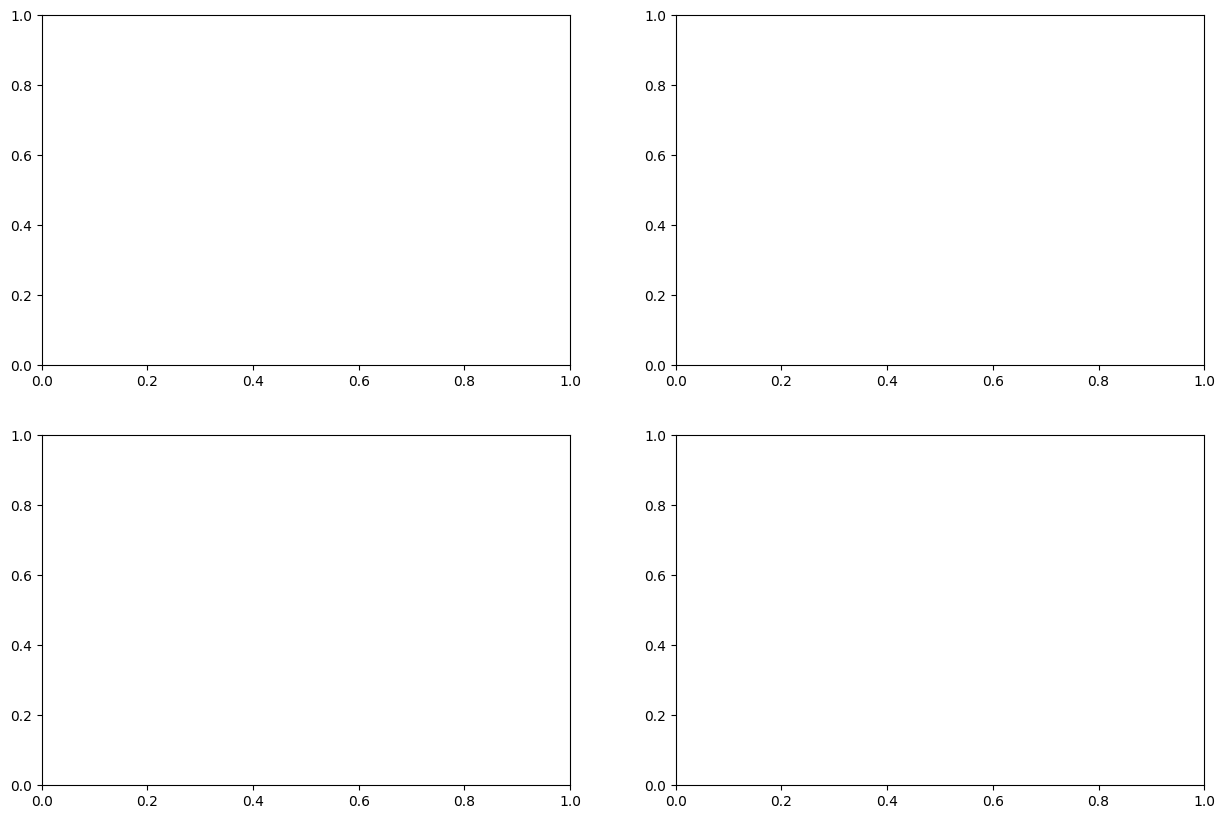

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

In [17]:
# График точности
axes[0, 0].plot(range(1, 4), results_resnet['test_accs'], 'o-', label='ResNet-18', linewidth=2, markersize=8)
axes[0, 0].plot(range(1, 4), results_vgg['test_accs'], 's-', label='VGG-16', linewidth=2, markersize=8)
axes[0, 0].plot(range(1, 4), results_inception['test_accs'], '^-', label='Inception v3', linewidth=2, markersize=8)
axes[0, 0].plot(range(1, 4), results_densenet['test_accs'], 'd-', label='DenseNet-161', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Эпоха', fontsize=12)
axes[0, 0].set_ylabel('Точность на тесте', fontsize=12)
axes[0, 0].set_title('Точность моделей на тестовом наборе', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks([1, 2, 3])

In [18]:
# График потерь
axes[0, 1].plot(range(1, 4), results_resnet['train_losses'], 'o-', label='ResNet-18', linewidth=2, markersize=8)
axes[0, 1].plot(range(1, 4), results_vgg['train_losses'], 's-', label='VGG-16', linewidth=2, markersize=8)
axes[0, 1].plot(range(1, 4), results_inception['train_losses'], '^-', label='Inception v3', linewidth=2, markersize=8)
axes[0, 1].plot(range(1, 4), results_densenet['train_losses'], 'd-', label='DenseNet-161', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Эпоха', fontsize=12)
axes[0, 1].set_ylabel('Потери на обучении', fontsize=12)
axes[0, 1].set_title('Потери моделей на обучающем наборе', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks([1, 2, 3])

In [19]:
# График времени обучения
models = ['ResNet-18', 'VGG-16', 'Inception v3', 'DenseNet-161']
times = [sum(results_resnet['times']), sum(results_vgg['times']),
         sum(results_inception['times']), sum(results_densenet['times'])]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = axes[1, 0].bar(models, times, color=colors, alpha=0.7)
axes[1, 0].set_xlabel('Модель', fontsize=12)
axes[1, 0].set_ylabel('Общее время обучения (сек)', fontsize=12)
axes[1, 0].set_title('Время обучения моделей (3 эпохи)', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

In [20]:
# Добавляем значения на столбцы
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(times)*0.02,
                   f'{time_val:.1f}s', ha='center', va='bottom', fontsize=10)

In [21]:
# Сравнение финальной точности
final_acc = [results_resnet['test_accs'][-1], results_vgg['test_accs'][-1],
             results_inception['test_accs'][-1], results_densenet['test_accs'][-1]]
bars = axes[1, 1].bar(models, final_acc, color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Модель', fontsize=12)
axes[1, 1].set_ylabel('Финальная точность', fontsize=12)
axes[1, 1].set_title('Финальная точность на тестовом наборе', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim([0, 1.0])

(0.0, 1.0)

In [22]:
# Добавляем значения на столбцы
for bar, acc in zip(bars, final_acc):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

In [23]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [24]:
# Вывод лучшей модели
best_model_idx = final_acc.index(max(final_acc))
best_model = models[best_model_idx]
print(f"\n{'='*60}")
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model}")
print(f"Точность: {final_acc[best_model_idx]:.4f}")
print(f"Время обучения: {times[best_model_idx]:.1f} сек")
print('='*60)


ЛУЧШАЯ МОДЕЛЬ: VGG-16
Точность: 0.9290
Время обучения: 254.9 сек


## Дополнительная информация

In [25]:
print(f"Датасет: EMNIST Letters ({num_classes} классов)")
print(f"Batch size: {BATCH_SIZE} (ResNet, VGG, DenseNet), 64 (Inception)")
print(f"Батчей на эпоху: 126")
print(f"Всего эпох: 3")
print(f"Используемое устройство: {device}")
print(f"Размер изображений: 224x224 (ResNet, VGG, DenseNet), 299x299 (Inception)")
print(f"Аугментация: RandomRotation(10), RandomAffine(translate=0.1)")
print(f"Оптимизатор: AdamW с learning rate decay")
print(f"Learning rate: 0.0003 (ResNet, VGG), 0.0002 (Inception, DenseNet)")
print(f"Стратегия: Fine-tuning последних слоев предобученных моделей")

Датасет: EMNIST Letters (27 классов)
Batch size: 128 (ResNet, VGG, DenseNet), 64 (Inception)
Батчей на эпоху: 126
Всего эпох: 3
Используемое устройство: cuda
Размер изображений: 224x224 (ResNet, VGG, DenseNet), 299x299 (Inception)
Аугментация: RandomRotation(10), RandomAffine(translate=0.1)
Оптимизатор: AdamW с learning rate decay
Learning rate: 0.0003 (ResNet, VGG), 0.0002 (Inception, DenseNet)
Стратегия: Fine-tuning последних слоев предобученных моделей
